Copyright **`(c)`** 2024 Giovanni Squillero `<giovanni.squillero@polito.it>`  
[`https://github.com/squillero/computational-intelligence`](https://github.com/squillero/computational-intelligence)  
Free under certain conditions — see the [`license`](https://github.com/squillero/computational-intelligence/blob/master/LICENSE.md) for details.  

# Credits

The current notebook has been developed by Dragos Buhnila, based on the initial implementation of Professor Squillero.  
Apart from the initial configuration, the code was written autonomously, with concepts found on the internet but no code ripped off, and some help from github copilot when browsing would take too much.  

In [1]:
from itertools import combinations
from collections import deque
import numpy as np
import random
from geopy.distance import geodesic
import networkx as nx

import pandas as pd
import logging
import pickle
import os
import matplotlib.pyplot as plt
from tqdm import tqdm
import sys

from typing import Tuple

logging.basicConfig(level=logging.DEBUG)

# Initialization

In [2]:
def init_all_cities() -> Tuple[dict, dict]:
    ALL_CITIES = {}
    ALL_DIST_MATRIX = {}
    countries = []

    for country in os.listdir('cities'):
        if country.endswith('.csv'):
            country = country[:-4]
            countries.append(country)

    for country in countries:
        # Read the CSV file
        ALL_CITIES[country] = pd.read_csv(f'cities/{country}.csv', header=None, names = ['name', 'lat', 'lon'])

        # Calculate distances between all cities
        cur_dist_matrix = np.zeros((len(ALL_CITIES[country]), len(ALL_CITIES[country])))
        for c1, c2 in combinations(ALL_CITIES[country].itertuples(), 2):
            cur_dist_matrix[c1.Index, c2.Index] = cur_dist_matrix[c2.Index, c1.Index] = geodesic((c1.lat, c1.lon), (c2.lat, c2.lon)).km
        ALL_DIST_MATRIX[country] = cur_dist_matrix

    return ALL_CITIES, ALL_DIST_MATRIX

ALL_CITIES, ALL_DIST_MATRIX = init_all_cities()

# Helper Functions

### General

In [3]:
def tsp_cost(tsp: list[int]) -> float:
    # Check that the TSP is a cycle and that all cities have been covered
    assert tsp[0] == tsp[-1], f"first city is #{tsp[0]}, last city is #{tsp[-1]}"
    # logging.debug(f"set(tsp): {set(tsp)}\nset(range(len(tsp))): {set(range(len(tsp)))}")
    assert set(tsp) == set(range(len(tsp) - 1)), f"tsp covers {len(tsp)}, should cover {len(tsp) - 1}"

    # Finally, compute the total cost
    tot_cost = 0
    for c1, c2 in zip(tsp, tsp[1:]):
        tot_cost += DIST_MATRIX[c1, c2]

    return tot_cost

def print_tsp(tsp: list):
    first = True
    for city in tsp:
        if first:
            prev_city = city
            first = False
            continue

        logging.info(f"step: {CITIES.at[prev_city,'name']} -> {CITIES.at[city,'name']} ({DIST_MATRIX[prev_city, city]:.2f}km)")
        prev_city = city

    logging.info(f"result: Found a path of {len(tsp)-1} steps, total length {tsp_cost(tsp):.2f}km")



### Segments

In [4]:
def tsp_segment_to_series(tsp: list[tuple]) -> list[int]:
    # Convert the list of segments to a list of cities
    tsp_series = [t[0] for t in tsp]
    tsp_series.append(tsp[0][0])
    return tsp_series


# def print_tsp_segments(tsp: list):
#     # logging.info(f"Total cost: {tsp_cost(tsp):.2f}km")

#     for segment in tsp:
#         city1, city2 = segment
#         logging.info(f"step: {CITIES.at[city1,'name']} -> {CITIES.at[city2,'name']} ({DIST_MATRIX[city1, city2]:.2f}km)")


def complete_segment_tsp(tsp: list[tuple], degrees: list[int]) -> list[tuple]:
    assert len(degrees) == len(CITIES), f"len(degrees)={len(degrees)} != len(CITIES)={len(CITIES)}"
    assert all (degree > 0 for degree in degrees), f"degrees={degrees} should be all > 0"

    indices_with_value_1 = [index for index, value in enumerate(degrees) if value == 1]
    assert len(indices_with_value_1) == 2, f"len(indices_with_value_1)={len(indices_with_value_1)} != 2"
    tsp.append((indices_with_value_1[0], indices_with_value_1[1]))

    return tsp

def order_segments(segments: list[tuple]) -> list[tuple]:
    # Create a dictionary to map each node to its connected nodes
    connections = {}
    for u, v in segments:
        if u in connections:
            connections[u].append(v)
        else:
            connections[u] = [v]
        if v in connections:
            connections[v].append(u)
        else:
            connections[v] = [u]

    # Start with the first segment in the list
    ordered_segments = [segments[0]]
    current = segments[0][1]

    # Reorder the list by following the connections
    while len(ordered_segments) < len(segments):
        next_city = connections[current].pop()
        connections[next_city].remove(current)
        next_segment = (current, next_city)
        ordered_segments.append(next_segment)
        current = next_city

    return ordered_segments


# Lab2 - TSP

https://www.wolframcloud.com/obj/giovanni.squillero/Published/Lab2-tsp.nb

In [12]:
def initialize(country: str):
    CITIES = ALL_CITIES[country]
    DIST_MATRIX = ALL_DIST_MATRIX[country]

    return CITIES, DIST_MATRIX

COUNTRY = 'italy'
CITIES, DIST_MATRIX = initialize(COUNTRY)

logging.info(f'Loaded {len(CITIES)} cities in {COUNTRY}')

INFO:root:Loaded 46 cities in italy


### Recursive Solution - Find Best Possible
It's clear that this kind of solution is only viable for small enough instances. (It seems like italy is already too much :( )

In [13]:
# Increase recursion limit if necessary
sys.setrecursionlimit(10000)

# Initialize globals
n_cities = len(CITIES)
best_path = None
best_cost = np.inf
steps = 0
pruned = 0

def tsp_recursive(current_city, visited, path, current_cost):
    global best_cost, best_path, steps, pruned
    steps += 1
    if steps % 10000000 == 0:
        logging.debug(f"step #{steps}")
    if len(path) == n_cities:
        # Complete the tour by returning to the starting city
        total_cost = current_cost + DIST_MATRIX[current_city][path[0]]
        if total_cost < best_cost:
            best_cost = total_cost
            best_path = path.copy() + [path[0]]
        return
    
    # Prune paths that exceed the current best cost
    if current_cost >= best_cost:
        pruned += 1
        if pruned % 10000000 == 0:
            logging.debug(f"pruned #{pruned}")
        return
    

    for next_city in range(n_cities):
        if not visited[next_city]:
            visited[next_city] = True
            path.append(next_city)
            tsp_recursive(next_city, visited, path, current_cost + DIST_MATRIX[current_city][next_city])
            visited[next_city] = False
            path.pop()

# Initialize variables
visited = [False] * n_cities
start_city = 0
visited[start_city] = True
path = [start_city]

tsp_recursive(start_city, visited, path, 0)

logging.info(f"Best path found with length {best_cost:.2f} km")
logging.info(f"Path is: {best_path}")

# Save the best tour
tsp_optimal = best_path
with open(f'./tsp_pickles/{COUNTRY}_tsp_recursive.pkl', 'wb') as file:
    pickle.dump(tsp_optimal, file)

print_tsp(tsp_optimal)

DEBUG:root:step #10000000
DEBUG:root:pruned #10000000
DEBUG:root:step #20000000
DEBUG:root:pruned #20000000
DEBUG:root:step #30000000
DEBUG:root:step #40000000
DEBUG:root:pruned #30000000
DEBUG:root:step #50000000
DEBUG:root:pruned #40000000
DEBUG:root:step #60000000
DEBUG:root:pruned #50000000
DEBUG:root:step #70000000
DEBUG:root:step #80000000
DEBUG:root:pruned #60000000
DEBUG:root:step #90000000
DEBUG:root:pruned #70000000
DEBUG:root:step #100000000
DEBUG:root:pruned #80000000
DEBUG:root:step #110000000


KeyboardInterrupt: 

### Greedy Solution 1 - Closest Cities Trasversal
The first greedy solution is able to find performance that is almost on par with that of the second one (Shortest Segment) by using an incredibly small fraction of the second's computing time (e.g. 1.2s vs 10m for the China instance)

In [ ]:
visited = np.full(len(CITIES), False)
dist = DIST_MATRIX.copy()
city = 0
visited[city] = True

tsp = list()
tsp.append(int(city))

while not np.all(visited):
    dist[:, city] = np.inf
    closest = np.argmin(dist[city])
    logging.debug(f"step: {CITIES.at[city,'name']} -> {CITIES.at[closest,'name']} ({DIST_MATRIX[city,closest]:.2f}km)")
    
    visited[closest] = True
    city = closest
    tsp.append(int(city))
    
logging.debug(f"step: {CITIES.at[tsp[-1],'name']} -> {CITIES.at[tsp[0],'name']} ({DIST_MATRIX[tsp[-1],tsp[0]]:.2f}km)")
tsp.append(tsp[0])

tot_cost = tsp_cost(tsp)
logging.info(f"result: Found a path of {len(tsp)-1} steps, total length {tot_cost:.2f}km")

with open(f'./tsp_pickles/{COUNTRY}_tsp_greedy1.pkl', 'wb') as file:
    pickle.dump(tsp, file)
tsp_greedy_1 = tsp

DEBUG:root:step: Ancona -> Rimini (90.60km)
DEBUG:root:step: Rimini -> Forlì (46.72km)
DEBUG:root:step: Forlì -> Ravenna (26.46km)
DEBUG:root:step: Ravenna -> Ferrara (66.67km)
DEBUG:root:step: Ferrara -> Bologna (43.43km)
DEBUG:root:step: Bologna -> Modena (37.29km)
DEBUG:root:step: Modena -> Reggio nell'Emilia (23.94km)


DEBUG:root:step: Reggio nell'Emilia -> Parma (26.94km)
DEBUG:root:step: Parma -> Piacenza (57.65km)
DEBUG:root:step: Piacenza -> Milan (60.65km)
DEBUG:root:step: Milan -> Monza (14.51km)
DEBUG:root:step: Monza -> Bergamo (33.92km)
DEBUG:root:step: Bergamo -> Brescia (46.02km)
DEBUG:root:step: Brescia -> Verona (61.42km)
DEBUG:root:step: Verona -> Vicenza (44.70km)
DEBUG:root:step: Vicenza -> Padua (30.13km)
DEBUG:root:step: Padua -> Venice (36.07km)
DEBUG:root:step: Venice -> Trieste (115.09km)
DEBUG:root:step: Trieste -> Bolzano (209.68km)
DEBUG:root:step: Bolzano -> Trento (49.94km)
DEBUG:root:step: Trento -> Novara (206.69km)
DEBUG:root:step: Novara -> Turin (84.46km)
DEBUG:root:step: Turin -> Genoa (123.19km)
DEBUG:root:step: Genoa -> Leghorn (146.37km)
DEBUG:root:step: Leghorn -> Prato (74.02km)
DEBUG:root:step: Prato -> Florence (17.17km)
DEBUG:root:step: Florence -> Perugia (119.19km)
DEBUG:root:step: Perugia -> Terni (63.64km)
DEBUG:root:step: Terni -> Rome (76.54km)
DEBUG:root

### Greedy Solution 2: Shortest Segments

In [ ]:
# Define the segments as ((city1, city2), distance) nested tuples
all_segments = list(combinations(range(len(CITIES)), 2))
all_segments = [((i, j), DIST_MATRIX[i, j]) for i, j in all_segments]
# Then define the tsp as a list of segments and the union-find data structure
uf = nx.utils.UnionFind()
tsp = list()
cities_degrees = [0] * len(CITIES) # Degree as in how many connections/segments

all_segments_empty = False
while not all_segments_empty:
    # Extract (i.e. also remove) the shortest segment
    shortest_seg = min(all_segments, key=lambda x: x[1])
    all_segments.remove(shortest_seg)
    shortest_seg = shortest_seg[0]  # Remove the distance from the tuple

    # Check if the two cities are already connected AND if the vertices are peripheral
    different_sets = uf[shortest_seg[0]] != uf[shortest_seg[1]]
    peripheral_vertices = cities_degrees[shortest_seg[0]] < 2 and cities_degrees[shortest_seg[1]] < 2
    if different_sets and peripheral_vertices:
        # Update the uf and the tsp
        uf.union(*shortest_seg)         # * is the unpacking operator
        tsp.append(shortest_seg)
        # Update the degrees of the cities
        cities_degrees[shortest_seg[0]] += 1
        cities_degrees[shortest_seg[1]] += 1

    all_segments_empty = len(all_segments) == 0
    
# Close the cycle and reorder it 
tsp = complete_segment_tsp(tsp, cities_degrees)
tsp = order_segments(tsp)

# Convert the list of segments to a list of cities
tsp = tsp_segment_to_series(tsp)
print_tsp(tsp)

with open(f'./tsp_pickles/{COUNTRY}_tsp_greedy2.pkl', 'wb') as file:
    pickle.dump(tsp, file)

tsp_greedy_2 = tsp


INFO:root:step: Giugliano in Campania -> Naples (11.15km)
INFO:root:step: Naples -> Salerno (46.25km)
INFO:root:step: Salerno -> Foggia (109.52km)
INFO:root:step: Foggia -> Andria (67.42km)
INFO:root:step: Andria -> Bari (50.18km)
INFO:root:step: Bari -> Taranto (77.63km)
INFO:root:step: Taranto -> Pescara (335.25km)
INFO:root:step: Pescara -> Syracuse (605.55km)
INFO:root:step: Syracuse -> Catania (51.23km)
INFO:root:step: Catania -> Reggio di Calabria (84.28km)
INFO:root:step: Reggio di Calabria -> Messina (12.48km)
INFO:root:step: Messina -> Palermo (192.10km)
INFO:root:step: Palermo -> Cagliari (390.28km)
INFO:root:step: Cagliari -> Sassari (173.89km)
INFO:root:step: Sassari -> Leghorn (344.66km)
INFO:root:step: Leghorn -> Prato (74.02km)
INFO:root:step: Prato -> Florence (17.17km)
INFO:root:step: Florence -> Trento (255.78km)
INFO:root:step: Trento -> Bolzano (49.94km)
INFO:root:step: Bolzano -> Trieste (209.68km)
INFO:root:step: Trieste -> Venice (115.09km)
INFO:root:step: Venice

# Comparison

Processing TSP files:   0%|          | 0/10 [00:00<?, ?it/s]

Processing TSP files: 100%|██████████| 10/10 [00:00<00:00, 165.64it/s]


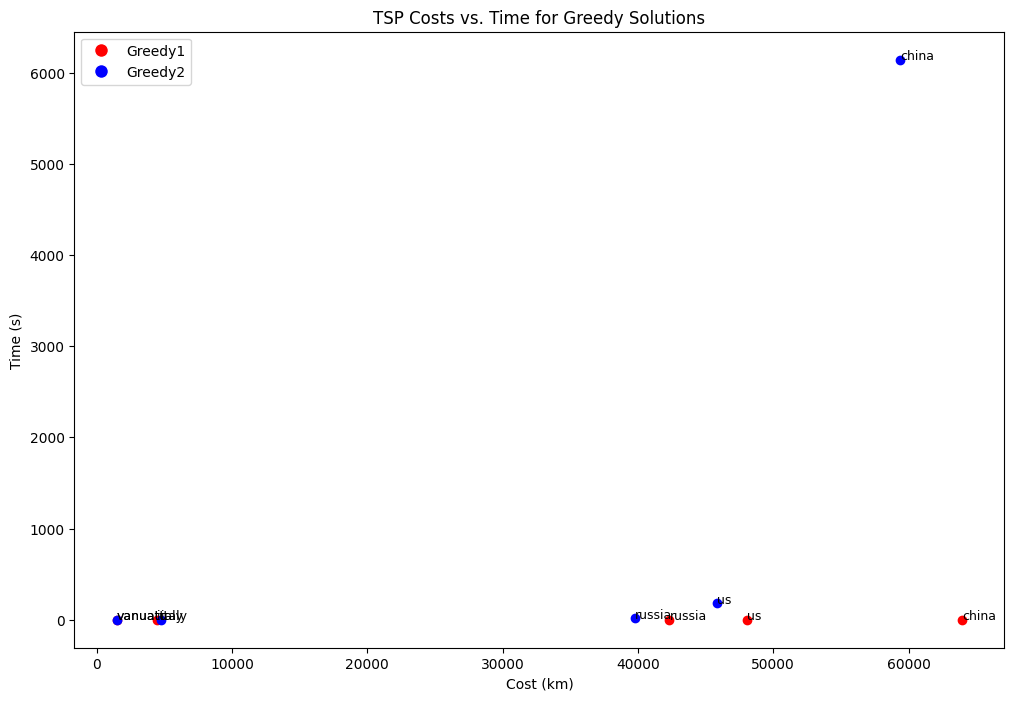

In [ ]:
def load_all_pkl_files(directory):
    # Take only files containing .pkl and greedy
    pkl_files = [f for f in os.listdir(directory) if f.endswith('.pkl')]
    pkl_files = [f for f in pkl_files if 'greedy' in f]

    # Load all the data
    data = {}
    for pkl_file in pkl_files:
        with open(os.path.join(directory, pkl_file), 'rb') as file:
            data[pkl_file] = pickle.load(file)
    return data


directory = './tsp_pickles'
all_data = load_all_pkl_files(directory)

times = {"china_tsp_greedy1.pkl": 1.2,
         "china_tsp_greedy2.pkl": 6142.5,
         "italy_tsp_greedy1.pkl": 0.1,
         "italy_tsp_greedy2.pkl": 0.1,
         "russia_tsp_greedy1.pkl": 0.2,
         "russia_tsp_greedy2.pkl": 15.3,
         "us_tsp_greedy1.pkl": 0.5,
         "us_tsp_greedy2.pkl": 180.0,
         "vanuatu_tsp_greedy1.pkl": 0.0,
         "vanuatu_tsp_greedy2.pkl": 0.0}

plt.figure(figsize=(12, 8))

# Define the legend patches
red_patch = plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='r', markersize=10, label='Greedy1')
blue_patch = plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='b', markersize=10, label='Greedy2')

# Plot the scatter points
for name, tsp in tqdm(all_data.items(), desc="Processing TSP files"):
    CITIES, DIST_MATRIX = initialize(name.split('_')[0])

    cost = tsp_cost(tsp)
    time = times[name]
    color = 'r' if 'greedy1' in name else 'b'

    plt.scatter(cost, time, color=color)
    plt.text(cost, time, name.split('_')[0], fontsize=9)

# Add the legend patches
plt.legend(handles=[red_patch, blue_patch])
plt.ylabel('Time (s)')
plt.xlabel('Cost (km)')
plt.title('TSP Costs vs. Time for Greedy Solutions')
plt.show()

As one can see, the extra time needed to compute the slightly better solution using greedy solution 2 is not worth it probably.  
Keep in mind though that the implementation of the second greedy solution could be optimized, maybe even by a lot, but I believe that the results would still hold, based on the level of efficiency I estimated my developed code to have.

This could be already considered an example analysis of the goal of the current laboratory, which was stated to be — alongside the exploration of solutions to the tsp — the finding of solutions that have slightly worse results than the best presented, but can find them much faster. Anyway, I will keep exploring other solutions using evolution and genetic operators.

In [10]:
import os
import pickle
import pandas as pd
from tqdm import tqdm

def load_all_pkl_files(directory):
    # Take only files containing .pkl and greedy
    pkl_files = [f for f in os.listdir(directory) if f.endswith('.pkl')]
    pkl_files = [f for f in pkl_files if 'greedy' in f]

    # Load all the data
    data = {}
    for pkl_file in pkl_files:
        with open(os.path.join(directory, pkl_file), 'rb') as file:
            data[pkl_file] = pickle.load(file)
    return data

directory = './tsp_pickles'
all_data = load_all_pkl_files(directory)

times = {
    "china_tsp_greedy1.pkl": 1.2,
    "china_tsp_greedy2.pkl": 6142.5,
    "italy_tsp_greedy1.pkl": 0.1,
    "italy_tsp_greedy2.pkl": 0.1,
    "russia_tsp_greedy1.pkl": 0.2,
    "russia_tsp_greedy2.pkl": 15.3,
    "us_tsp_greedy1.pkl": 0.5,
    "us_tsp_greedy2.pkl": 180.0,
    "vanuatu_tsp_greedy1.pkl": 0.0,
    "vanuatu_tsp_greedy2.pkl": 0.0
}

# Collect data for the table
table_data = []

for name, tsp in tqdm(all_data.items(), desc="Processing TSP files"):
    country = name.split('_')[0]
    algorithm = 'Greedy1' if 'greedy1' in name else 'Greedy2'
    CITIES, DIST_MATRIX = initialize(country)
    cost = tsp_cost(tsp)
    time = times[name]
    table_data.append({
        'Country': country,
        'Algorithm': algorithm,
        'Cost (km)': cost,
        'Time (s)': time
    })

# Create DataFrame
df = pd.DataFrame(table_data)

# Optionally, sort the DataFrame
df = df.sort_values(by=['Country', 'Algorithm'])

# Print the table
print(df.to_string(index=False))

Processing TSP files: 100%|██████████| 10/10 [00:00<00:00, 2502.27it/s]

Country Algorithm    Cost (km)  Time (s)
  china   Greedy1 63962.918429       1.2
  china   Greedy2 59367.316192    6142.5
  italy   Greedy1  4436.031770       0.1
  italy   Greedy2  4730.052334       0.1
 russia   Greedy1 42334.164657       0.2
 russia   Greedy2 39758.479041      15.3
     us   Greedy1 48050.025864       0.5
     us   Greedy2 45845.918712     180.0
vanuatu   Greedy1  1475.528091       0.0
vanuatu   Greedy2  1475.528091       0.0
